# Init
## Libraries

In [210]:
import numpy as np
import random
from scipy.stats import norm, cauchy
from scipy.special import wofz
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Emission line profiles - Demos

## Gaussian

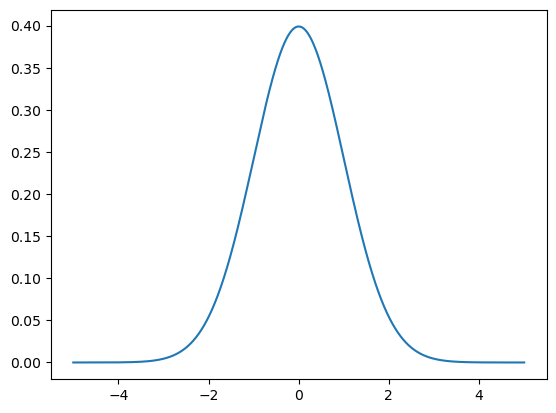

In [2]:
x = np.linspace(-5, 5, 1000)
y = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)

plt.plot(x, y)
plt.show()

## Lorentzian (Cauchy)

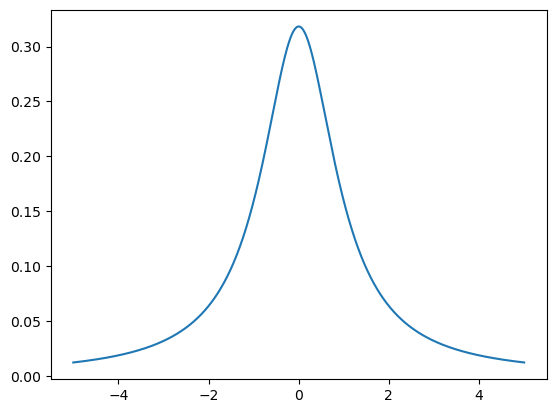

In [3]:
x = np.linspace(-5, 5, 1000)
y = cauchy.pdf(x, scale=1)

plt.plot(x, y)
plt.show()

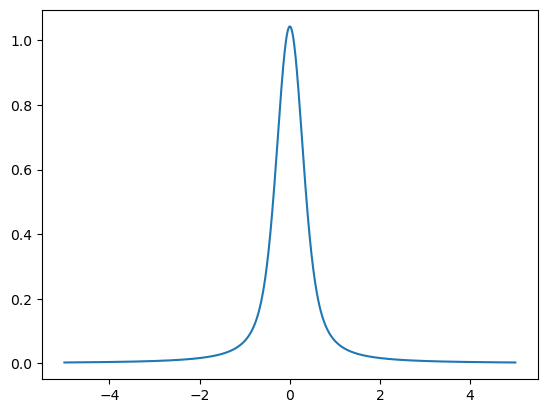

In [92]:
def voigt(x, sigma, gamma):
    z = (x + 1j*gamma)/(sigma*np.sqrt(2))
    return np.real(wofz(z))/(sigma*np.sqrt(2*np.pi))

x = np.linspace(-5, 5, 1000)
y = voigt(x, sigma=.2, gamma=.2)

plt.plot(x, y)
plt.show()

# Creating spectrum

In [256]:
def get_line_boundaries(line_profile: np.array) -> list:
    PERCENTILE_AT_BOUNDARY = .05
    line_max = np.max(line_profile)
    boundary_value = line_max * PERCENTILE_AT_BOUNDARY
    return (line_max, np.where(boundary_value <= line_profile)[0][[0,-1]])

def generate_random_profile(
    profile_length: int,
):
    sigma = np.random.uniform(0, 1)
    gamma = np.random.uniform(0, 1)
    x = np.linspace(-5, 5, profile_length)
    max_int = np.random.randint(65000)
    profile = random.sample([
        norm.pdf(x, loc=0, scale=sigma),
        cauchy.pdf(x, scale=gamma),
        voigt(x, sigma=sigma, gamma=gamma)
    ],1)

    return np.squeeze(profile) * max_int
    

In [251]:
SPECTRUM_LENGTH = 40000
PROFILE_LENGTH = 500

wavelengths = np.linspace(240, 900, SPECTRUM_LENGTH)

In [257]:
def add_profile_to_spectrum(
    spectrum: np.array,
    profile: np.array,
    shift: int
):
    spectrum[shift:(shift + len(profile))] += profile
    return spectrum

In [283]:
def generate_spectrum_with_profiles(
    wavelengths: np.array,
    line_count: int,
    profile_widths: int
) -> tuple:
    spectrum = np.zeros_like(wavelengths)
    box_coordinates = []
    line_maxima = []
    for _ in range(line_count):
        line_intensities = generate_random_profile(profile_widths)
        profile_start = np.random.randint(1, len(spectrum) - len(line_intensities))
        profile_box = get_line_boundaries(line_intensities)
        box_coordinates.append(
            profile_box[1] + profile_start
        )
        line_maxima.append(profile_box[0])
        spectrum = add_profile_to_spectrum(
            spectrum,
            line_intensities,
            shift=profile_start
        )
    return (spectrum, box_coordinates, line_maxima)

In [271]:
PROFILE_LENGTH
LINE_COUNT = 50

train_data = [
    generate_spectrum_with_profiles(
        wavelengths,
        line_count=LINE_COUNT,
        profile_widths=PROFILE_LENGTH
    )
    for x
    in range(10)
]

In [273]:
x_train = np.vstack([x[0] for x in train_data])
y_train = [x[1] for x in train_data]

In [281]:
y_train

[[array([11190, 11659], dtype=int64),
  array([12814, 13017], dtype=int64),
  array([22564, 22585], dtype=int64),
  array([23918, 24287], dtype=int64),
  array([23858, 23905], dtype=int64),
  array([38731, 38818], dtype=int64),
  array([23282, 23315], dtype=int64),
  array([26607, 27042], dtype=int64),
  array([37652, 38045], dtype=int64),
  array([19583, 19728], dtype=int64),
  array([6654, 6887], dtype=int64),
  array([34134, 34425], dtype=int64),
  array([10421, 10644], dtype=int64),
  array([35821, 35916], dtype=int64),
  array([8447, 8524], dtype=int64),
  array([19865, 19962], dtype=int64),
  array([21939, 22222], dtype=int64),
  array([2030, 2317], dtype=int64),
  array([19159, 19300], dtype=int64),
  array([16633, 16646], dtype=int64),
  array([16817, 17082], dtype=int64),
  array([13316, 13491], dtype=int64),
  array([2726, 2841], dtype=int64),
  array([30689, 30800], dtype=int64),
  array([37359, 37420], dtype=int64),
  array([19308, 19369], dtype=int64),
  array([32954, 3338

In [265]:
box_starts = [x[0] for x in box_coordinates]
box_ends = [x[-1] for x in box_coordinates]

In [267]:
boxes = list()
for line_maximum, box_start, box_end in zip(line_maxima, box_starts, box_ends):
    boxes.append(
        go.layout.Shape(
            type='rect',
            x0=wavelengths[box_start],
            x1=wavelengths[box_end],
            y0=0,
            y1=line_maximum * 1.2,
            fillcolor='rgba(255, 0, 0, 0.2)', 
            line=dict(
                width=2, 
                color='rgba(0, 0, 255, 1)'
            )
        )
    )

fig = go.Figure(
    layout=go.Layout(shapes=boxes)
)
fig.add_trace(
    go.Scatter(
        x=wavelengths, 
        y=spectrum
    )
)
fig.show()